In [1]:
import torch
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabrepo import load_repository
from probmetrics.metrics import Metrics
from probmetrics.calibrators import get_calibrator

import warnings
warnings.simplefilter("ignore")

We solve the following convex optimization problem:
$$
\frac{1}{n} \sum_{i=1}^n \ell(S((aI + \text{diag}(\mathbf{v}) + M \odot (11^\top-I)) \mathbf{z}_i + \mathbf{b}), y_i) + \lambda_\mathbf{b} \frac{k^\rho}{n^\tau}\|\mathbf{b}\|_\alpha + \lambda_\mathbf{v} \frac{k^\rho}{n^\tau}\|\mathbf{v}\|_\alpha + \lambda_M \frac{((k-1)k)^\rho}{n^\tau}\|\mathbf{M}\|_\alpha \quad .
$$

We experiment with the following parameters:
- $\alpha$ the order of the norm is $1$ (lasso), $2$ (group-lasso) or $2$-squared (ridge).
- $\rho$ the power of the number of parameters in $\{-1, -0.5, 0, 0.5, 1 \}$.
- $\tau$ the power of the number of samples is $\{0.5, 1, 1.5, 2 \}$.
- $\lambda_\mathbf{b}$, $\lambda_\mathbf{v}$, $\lambda_M$ the intercept, diagonal and off-diagonal regularization coefficients in the range $[0.01, 100]$.

In [2]:
repo = load_repository("D244_F3_C1530_200")
configs = pd.read_csv('results/multiclass/configs.csv')

start: Loading ZS Context
Loading BenchmarkContext:
	name: D244_F3_C1530_200
	description: Large-scale Benchmark on 244 datasets and 3 folds (120 GB, 200 smallest datasets)
	date: 2023_11_14
	folds: [0, 1, 2]
All required files are present...
Loading input files...
	configs :           /Users/eberta/.cache/tabrepo/data/results/2023_11_14/configs.parquet
	metadata:           /Users/eberta/.cache/tabrepo/data/results/2023_11_14/task_metadata.csv
Loading baselines: /Users/eberta/.cache/tabrepo/data/results/2023_11_14/baselines.parquet
Loading config hyperparameter definitions... Note: Hyperparameter definitions are only accurate for the latest version.
Loading ZS inputs:
	pred_proba:  /Users/eberta/.cache/tabrepo/data/results/2023_11_14/model_predictions/

Aligning GroundTruth with TabularPredictions... (Dataset count 200 -> 200)
Time for Loading ZS Context: 8.9168 secs


In [3]:
def benchmark_multiclass_calibrator(
        repo,
        configs,
        calibrator,
        penalty=None,
        rho=None,
        tau=None,
        lambda_intercept=None,
        lambda_diagonal=None,
        lambda_off_diagonal=None
    ):

    if not(calibrator in ['ts', 'hvs', 'hms']):
        return ValueError('Unknown calibrator')

    metrics = Metrics.from_names(['brier'])
    results = []

    for _, row in configs.iterrows():
        dataset, fold, config = row['dataset'], row['fold'], row['tuned_config']
        try:
            p_val = repo.predict_val(dataset=dataset, fold=fold, config=config)
            y_val = repo.labels_val(dataset=dataset, fold=fold)
            p_test = repo.predict_test(dataset=dataset, fold=fold, config=config)
            y_test = repo.labels_test(dataset=dataset, fold=fold)
        except:
            pass

        n_val, k = p_val.shape
        n_test = len(y_test)

        # subsampling large datasets:
        if n_val > 10000:
            np.random.seed(123)
            idx = np.arange(0, n_val)
            rand_idx = np.random.choice(idx, 10000, replace=False)
            p_val = p_val[rand_idx]
            y_val = y_val[rand_idx]
            n_val = 10000

        r = {
            'dataset': dataset,
            'fold': fold,
            'config': config,
            'n_classes': k,
            'val_size': n_val,
            'test_size': n_test
        }

        # Initial test scores:
        base_metrics = metrics.compute_all_from_labels_probs(torch.as_tensor(y_test), torch.as_tensor(p_test))
        r.update({f'base_{key}': value.item() for key, value in base_metrics.items()})

        # With re-calibration:
        if calibrator=='ts':
            cal = get_calibrator('linear-scaling')
        elif calibrator=='hvs':
            cal = get_calibrator('hvs',
                                 hvs_penalty=penalty,
                                 hvs_rho=rho,
                                 hvs_tau=tau,
                                 hvs_lambda_intercept=lambda_intercept,
                                 hvs_lambda_diagonal=lambda_diagonal)
        elif calibrator=='hms':
            cal = get_calibrator('hms',
                                 hms_penalty=penalty,
                                 hms_rho=rho,
                                 hms_tau=tau,
                                 hms_lambda_intercept=lambda_intercept,
                                 hms_lambda_diagonal=lambda_diagonal,
                                 hms_lambda_off_diagonal=lambda_off_diagonal)
        cal.fit(p_val, y_val)
        cal_metrics = metrics.compute_all_from_labels_probs(torch.as_tensor(y_test), torch.as_tensor(cal.predict_proba(p_test)))
        r.update({f'{calibrator}_{key}': value.item() for key, value in cal_metrics.items()})
        results.append(r)

    return pd.DataFrame(results)

In [4]:
# Splitting datasets in two for gridsearch and benchmark using ts effect:
df = benchmark_multiclass_calibrator(repo, configs, 'ts')
df = df.groupby(['dataset']).agg({'ts_brier':'mean', 'base_brier':'mean'}).reset_index()

multiclass_datasets = df.dataset.tolist()
ts_effect = (df.ts_brier - df.base_brier).tolist()

arg = np.argsort(ts_effect)
gridsearch_datasets = [multiclass_datasets[arg[2*i]] for i in range(len(ts_effect)//2)]
benchmark_datasets = [multiclass_datasets[arg[2*i+1]] for i in range(len(ts_effect)//2)]

gridsearch_configs = configs[configs.dataset.isin(gridsearch_datasets)]
benchmark_configs = configs[configs.dataset.isin(benchmark_datasets)]

First LinearScalingCalibrator instantiation - warming up Numba functions...
Warmed up!


In [5]:
# Evaluating TS on gridsearch datasets for reference:
gridsearch_ts = benchmark_multiclass_calibrator(repo, gridsearch_configs, 'ts')
print(f'TS median relative improvement {100.0*(gridsearch_ts.ts_brier / gridsearch_ts.base_brier - 1.0).median():.3f}%')
print(f'TS mean absolute improvement {(gridsearch_ts.ts_brier - gridsearch_ts.base_brier).mean():.5f}')

TS median relative improvement -0.019%
TS mean absolute improvement -0.00261


## HVS parameter gridsearch

### Ridge penalty

In [8]:
print('##### Hyper-parameter grid search for HVS with ridge penalty #####')
gaps, rels = [], []
for rho in [-1.0, -0.5, 0.0, 0.5, 1.0]:
    for tau in [0.5, 1.0, 1.5, 2.0]:
                df = benchmark_multiclass_calibrator(
                        repo, gridsearch_configs, calibrator='hvs', penalty='ridge', rho=rho, tau=tau,
                        lambda_intercept=1.0, lambda_diagonal=1.0)
                gap = (df.hvs_brier - df.base_brier).mean()
                gaps.append(gap)
                rel = (100.0*(df.hvs_brier / df.base_brier - 1.0)).median()
                rels.append(rel)
                print(f'rho {rho} | tau {tau} | avg Brier gap {gap:.5f} | avg Brier rel {rel:.3f}%')

##### Hyper-parameter grid search for HVS with ridge penalty #####
rho -1.0 | tau 0.5 | avg Brier gap -0.00334 | avg Brier rel -0.353%
rho -1.0 | tau 1.0 | avg Brier gap -0.00338 | avg Brier rel -0.400%
rho -1.0 | tau 1.5 | avg Brier gap -0.00337 | avg Brier rel -0.390%
rho -1.0 | tau 2.0 | avg Brier gap -0.00337 | avg Brier rel -0.390%
rho -0.5 | tau 0.5 | avg Brier gap -0.00330 | avg Brier rel -0.338%
rho -0.5 | tau 1.0 | avg Brier gap -0.00338 | avg Brier rel -0.405%
rho -0.5 | tau 1.5 | avg Brier gap -0.00337 | avg Brier rel -0.390%
rho -0.5 | tau 2.0 | avg Brier gap -0.00337 | avg Brier rel -0.390%
rho 0.0 | tau 0.5 | avg Brier gap -0.00320 | avg Brier rel -0.271%
rho 0.0 | tau 1.0 | avg Brier gap -0.00340 | avg Brier rel -0.401%
rho 0.0 | tau 1.5 | avg Brier gap -0.00337 | avg Brier rel -0.389%
rho 0.0 | tau 2.0 | avg Brier gap -0.00337 | avg Brier rel -0.390%
rho 0.5 | tau 0.5 | avg Brier gap -0.00305 | avg Brier rel -0.200%
rho 0.5 | tau 1.0 | avg Brier gap -0.00342 | avg Brier

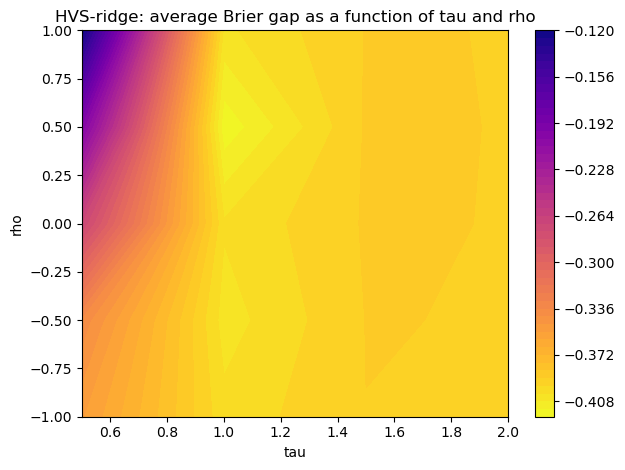

In [12]:
Rels = np.array(rels).reshape(5, 4)
Tau, Rho = np.meshgrid([0.5, 1.0, 1.5, 2.0], [-1.0, -0.5, 0.0, 0.5, 1.0])

plt.figure()
contour = plt.contourf(Tau, Rho, Rels, levels=50, cmap='plasma_r')
plt.colorbar(contour)
plt.xlabel('tau')
plt.ylabel('rho')
plt.title('HVS-ridge: average Brier gap as a function of tau and rho')
plt.tight_layout()
plt.show()

In [13]:
gaps, rels = [], []
for lambda_intercept in [0.01, 0.1, 1.0, 10.0, 100.0]:
    for lambda_diagonal in [0.01, 0.1, 1.0, 10.0, 100.0]:
                df = benchmark_multiclass_calibrator(
                        repo, gridsearch_configs, calibrator='hvs', penalty='ridge', rho=0.5, tau=1.0,
                        lambda_intercept=lambda_intercept, lambda_diagonal=lambda_diagonal)
                gap = (df.hvs_brier - df.base_brier).mean()
                gaps.append(gap)
                rel = (100.0*(df.hvs_brier / df.base_brier - 1.0)).median()
                rels.append(rel)
                print(f'lambda_intercept {lambda_intercept} | lambda_diagonal {lambda_diagonal} | avg Brier gap {gap:.5f} | avg Brier rel {rel:.3f}%')

lambda_intercept 0.01 | lambda_diagonal 0.01 | avg Brier gap -0.00337 | avg Brier rel -0.390%
lambda_intercept 0.01 | lambda_diagonal 0.1 | avg Brier gap -0.00338 | avg Brier rel -0.390%
lambda_intercept 0.01 | lambda_diagonal 1.0 | avg Brier gap -0.00341 | avg Brier rel -0.395%
lambda_intercept 0.01 | lambda_diagonal 10.0 | avg Brier gap -0.00342 | avg Brier rel -0.336%
lambda_intercept 0.01 | lambda_diagonal 100.0 | avg Brier gap -0.00328 | avg Brier rel -0.262%
lambda_intercept 0.1 | lambda_diagonal 0.01 | avg Brier gap -0.00338 | avg Brier rel -0.390%
lambda_intercept 0.1 | lambda_diagonal 0.1 | avg Brier gap -0.00338 | avg Brier rel -0.400%
lambda_intercept 0.1 | lambda_diagonal 1.0 | avg Brier gap -0.00342 | avg Brier rel -0.397%
lambda_intercept 0.1 | lambda_diagonal 10.0 | avg Brier gap -0.00342 | avg Brier rel -0.336%
lambda_intercept 0.1 | lambda_diagonal 100.0 | avg Brier gap -0.00328 | avg Brier rel -0.271%
lambda_intercept 1.0 | lambda_diagonal 0.01 | avg Brier gap -0.0034

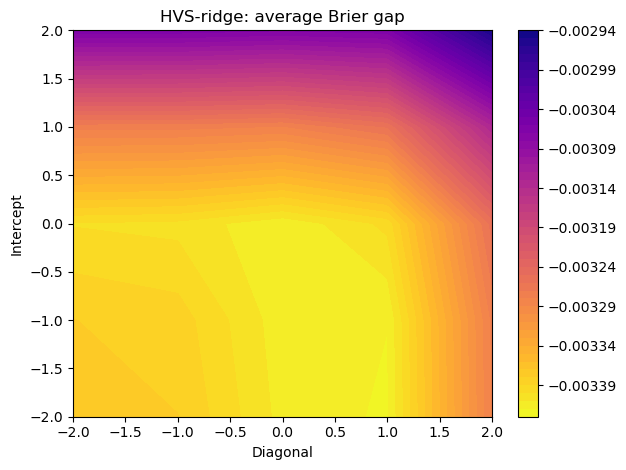

In [14]:
Gaps = np.array(gaps).reshape(5, 5)
Diagonal, Intercept = np.meshgrid(np.log10([0.01, 0.1, 1.0, 10.0, 100.0]), np.log10([0.01, 0.1, 1.0, 10.0, 100.0]))

plt.figure()
contour = plt.contourf(Diagonal, Intercept, Gaps, levels=50, cmap='plasma_r')
plt.colorbar(contour)
plt.xlabel('Diagonal')
plt.ylabel('Intercept')
plt.title('HVS-ridge: average Brier gap')
plt.tight_layout()
plt.show()

### Using Optuna:

In [17]:
def objective(trial):
    rho = trial.suggest_categorical('rho', [-1.0, -0.5, 0.0, 0.5, 1.0])
    tau = trial.suggest_categorical('tau', [0.5, 1.0, 1.5, 2.0])
    lambda_intercept = trial.suggest_float('lambda_intercept', 1e-3, 1e2, log=True)
    lambda_diagonal = trial.suggest_float('lambda_diagonal', 1e-3, 1e2, log=True)

    df = benchmark_multiclass_calibrator(
            repo, gridsearch_configs, calibrator='hvs', penalty='ridge',
            rho=rho, tau=tau, lambda_intercept=lambda_intercept, lambda_diagonal=lambda_diagonal)
    improvement = (100.0*(df.hvs_brier / df.base_brier - 1.0)).median()

    return improvement

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2025-09-16 10:51:39,167] A new study created in memory with name: no-name-5e7447d2-fd2c-4ea3-81ac-694473322399
[I 2025-09-16 10:52:32,918] Trial 0 finished with value: -0.389925975858324 and parameters: {'rho': 0.5, 'tau': 2.0, 'lambda_intercept': 0.1444670522810675, 'lambda_diagonal': 11.598093388425514}. Best is trial 0 with value: -0.389925975858324.
[I 2025-09-16 10:53:25,970] Trial 1 finished with value: -0.39017496454113454 and parameters: {'rho': -1.0, 'tau': 1.5, 'lambda_intercept': 0.023200779961098823, 'lambda_diagonal': 0.4734432193324752}. Best is trial 1 with value: -0.39017496454113454.
[I 2025-09-16 10:54:14,026] Trial 2 finished with value: -0.3297381788613274 and parameters: {'rho': -0.5, 'tau': 0.5, 'lambda_intercept': 2.938588815773273, 'lambda_diagonal': 0.0013335300588701888}. Best is trial 1 with value: -0.39017496454113454.
[I 2025-09-16 10:55:13,475] Trial 3 finished with value: -0.40969643794468436 and parameters: {'rho': 1.0, 'tau': 1.5, 'lambda_intercept':

In [18]:
study.best_params

{'rho': -0.5,
 'tau': 1.0,
 'lambda_intercept': 10.513096404628802,
 'lambda_diagonal': 0.004537353938898513}

gridsearch datasets:

In [20]:
df_opt = benchmark_multiclass_calibrator(
        repo, gridsearch_configs, calibrator='hvs', penalty='ridge', rho=study.best_params['rho'], tau=study.best_params['tau'],
        lambda_intercept=study.best_params['lambda_intercept'], lambda_diagonal=study.best_params['lambda_diagonal'])
gap_opt = (df_opt.hvs_brier - df_opt.base_brier).mean()
rel_opt = 100.0*(df_opt.hvs_brier / df_opt.base_brier - 1.0).median()

df_def = benchmark_multiclass_calibrator(
        repo, gridsearch_configs, calibrator='hvs', penalty='ridge', rho=1.0, tau=1.0,
        lambda_intercept=1.0, lambda_diagonal=1.0)
gap_def = (df_def.hvs_brier - df_def.base_brier).mean()
rel_def = 100.0*(df_def.hvs_brier / df_def.base_brier - 1.0).median()

print(f'Avg Brier gap default menu: {gap_def:.5f}, optimized menu: {gap_opt:.5f}.')
print(f'Avg Brier rel default menu: {rel_def:.5f}, optimized menu: {rel_opt:.5f}.')

Avg Brier gap default menu: -0.00341, optimized menu: -0.00337.
Avg Brier rel default menu: -0.40337, optimized menu: -0.43947.


benchmark datasets:

In [19]:
df_opt = benchmark_multiclass_calibrator(
        repo, benchmark_configs, calibrator='hvs', penalty='ridge', rho=study.best_params['rho'], tau=study.best_params['tau'],
        lambda_intercept=study.best_params['lambda_intercept'], lambda_diagonal=study.best_params['lambda_diagonal'])
gap_opt = (df_opt.hvs_brier - df_opt.base_brier).mean()
rel_opt = 100.0*(df_opt.hvs_brier / df_opt.base_brier - 1.0).median()

df_def = benchmark_multiclass_calibrator(
        repo, benchmark_configs, calibrator='hvs', penalty='ridge', rho=1.0, tau=1.0,
        lambda_intercept=1.0, lambda_diagonal=1.0)
gap_def = (df_def.hvs_brier - df_def.base_brier).mean()
rel_def = 100.0*(df_def.hvs_brier / df_def.base_brier - 1.0).median()

print(f'Avg Brier gap default menu: {gap_def:.5f}, optimized menu: {gap_opt:.5f}.')
print(f'Avg Brier rel default menu: {rel_def:.5f}, optimized menu: {rel_opt:.5f}.')

Avg Brier gap default menu: -0.00316, optimized menu: -0.00324.
Avg Brier rel default menu: -0.11703, optimized menu: -0.13918.


## HMS parameter gridsearch

### Ridge penalty

In [ ]:
print('##### Hyper-parameter grid search for HMS with ridge penalty #####')
gaps = []
for rho in [-1.0, -0.5, 0.0, 0.5, 1.0]:
    for tau in [0.5, 1.0, 1.5, 2.0]:
                df = benchmark_multiclass_calibrator(
                    repo, gridsearch_configs, calibrator='hms', penalty='ridge', rho=rho, tau=tau,
                    lambda_intercept=1.0, lambda_diagonal=1.0, lambda_off_diagonal=1.0)
                df.to_csv(f'results/multiclass/HMS/ridge/rho_{str(rho).replace('.', '')}_tau_{str(tau).replace('.', '')}_repo200.csv', index=False)
                gap = (df.hms_brier - df.base_brier).mean()
                gaps.append(gap)
                print(f'Time {df.hms_time.sum():6.2f}s | rho {rho} | tau {tau} | avg Brier gap {gap:.5f}')

##### Hyper-parameter grid search for HMS with ridge penalty #####
First HMSCalibrator instantiation - warming up Numba functions...
Warmed up!
Time 146.39s | rho -1.0 | tau 0.5 | avg Brier gap -0.00138
Time 149.87s | rho -1.0 | tau 1.0 | avg Brier gap -0.00084
Time 142.70s | rho -1.0 | tau 1.5 | avg Brier gap -0.00068
Time 141.90s | rho -1.0 | tau 2.0 | avg Brier gap -0.00067
Time  84.12s | rho -0.5 | tau 0.5 | avg Brier gap -0.00330
Time 146.51s | rho -0.5 | tau 1.0 | avg Brier gap -0.00106
Time 145.25s | rho -0.5 | tau 1.5 | avg Brier gap -0.00070
Time 145.32s | rho -0.5 | tau 2.0 | avg Brier gap -0.00066
Time  39.86s | rho 0.0 | tau 0.5 | avg Brier gap -0.00524
Time 129.79s | rho 0.0 | tau 1.0 | avg Brier gap -0.00279
Time 141.27s | rho 0.0 | tau 1.5 | avg Brier gap -0.00082
Time 150.31s | rho 0.0 | tau 2.0 | avg Brier gap -0.00066
Time  31.36s | rho 0.5 | tau 0.5 | avg Brier gap -0.00482
Time  57.68s | rho 0.5 | tau 1.0 | avg Brier gap -0.00535
Time 147.44s | rho 0.5 | tau 1.5 | a

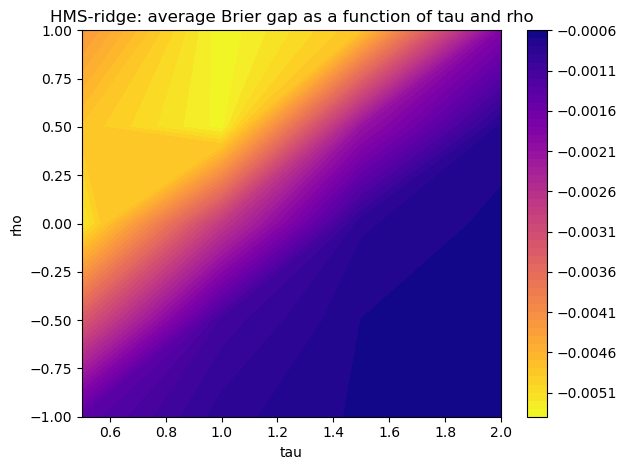

In [18]:
Gaps = np.array(gaps).reshape(5, 4)
Tau, Rho = np.meshgrid([0.5, 1.0, 1.5, 2.0], [-1.0, -0.5, 0.0, 0.5, 1.0])

plt.figure()
contour = plt.contourf(Tau, Rho, Gaps, levels=50, cmap='plasma_r')
plt.colorbar(contour)
plt.xlabel('tau')
plt.ylabel('rho')
plt.title('HMS-ridge: average Brier gap as a function of tau and rho')
plt.tight_layout()
plt.show()

### Using optuna

In [ ]:
def objective(trial):
    rho = trial.suggest_categorical('rho', [-0.5, 0.0, 0.5, 1.0])
    tau = trial.suggest_categorical('tau', [0.5, 1.0, 1.5])
    lambda_intercept_log2 = trial.suggest_int('lambda_intercept_log2', -2, 4)
    lambda_diagonal_log2 = trial.suggest_int('lambda_diagonal_log2', -2, 4)
    lambda_off_diagonal_log2 = trial.suggest_int('lambda_off_diagonal_log2', -2, 4)

    df = benchmark_multiclass_calibrator(
            repo, gridsearch_configs, calibrator='hms', penalty='ridge',
            rho=rho, tau=tau, lambda_intercept=2**lambda_intercept_log2, lambda_diagonal=2**lambda_diagonal_log2, lambda_off_diagonal=2**lambda_off_diagonal_log2)
    gap = (df.hms_brier - df.base_brier).mean()

    return gap

study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2025-07-18 16:39:16,745] A new study created in memory with name: no-name-f8fd2c26-6dac-4f5d-b17d-8d26467640d0


First HMSCalibrator instantiation - warming up Numba functions...
Warmed up!


[I 2025-07-18 16:40:16,703] Trial 0 finished with value: -0.004636313875752828 and parameters: {'rho': 0.0, 'tau': 0.5, 'lambda_intercept_log2': -2, 'lambda_diagonal_log2': 3, 'lambda_off_diagonal_log2': -2}. Best is trial 0 with value: -0.004636313875752828.
[I 2025-07-18 16:42:51,573] Trial 1 finished with value: -0.0012196367435933283 and parameters: {'rho': -0.5, 'tau': 1.0, 'lambda_intercept_log2': 1, 'lambda_diagonal_log2': -2, 'lambda_off_diagonal_log2': 1}. Best is trial 0 with value: -0.004636313875752828.
[I 2025-07-18 16:43:51,299] Trial 2 finished with value: -0.005575356696404869 and parameters: {'rho': 1.0, 'tau': 1.5, 'lambda_intercept_log2': 1, 'lambda_diagonal_log2': 0, 'lambda_off_diagonal_log2': 3}. Best is trial 2 with value: -0.005575356696404869.
[I 2025-07-18 16:44:57,051] Trial 3 finished with value: -0.005464418680593282 and parameters: {'rho': 1.0, 'tau': 1.5, 'lambda_intercept_log2': 2, 'lambda_diagonal_log2': 1, 'lambda_off_diagonal_log2': 2}. Best is trial 

In [14]:
study.best_params

{'rho': 1.0,
 'tau': 1.5,
 'lambda_intercept_log2': -1,
 'lambda_diagonal_log2': 3,
 'lambda_off_diagonal_log2': 4}